In [1]:
import nltk
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
import openpyxl as xl
from snowballstemmer import TurkishStemmer
import random
import matplotlib.pyplot as plt
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

In [2]:
# To open the workbook  
# workbook object is created 
wb_obj = xl.load_workbook("bank_data.xlsx")

# Get workbook active sheet object 
# from the active attribute 
sheet_obj = wb_obj.active 

# Cell objects also have a row, column,  
# and coordinate attributes that provide 
# location information for the cell. 

# Note: The first row or  
# column integer is 1, not 0.

# Cell object is created by using  
# sheet object's cell() method. 
cell_obj = sheet_obj.cell(row = 1, column = 1) 

# Print value of cell object  
# using the value attribute 
print(cell_obj.value, type(cell_obj.value))

raw text <class 'str'>


In [3]:
tot_row = sheet_obj.max_row #the total number of rows, including the first line
tot_col = sheet_obj.max_column #the total number of col

print(tot_row)

4757


In [4]:
documents = []
options = []
for i in range(2, tot_row): 
    cell_obj_statement = sheet_obj.cell(row = i, column = 2) 
    cell_obj_intent = sheet_obj.cell(row = i, column = 3)
    documents.append(cell_obj_statement.value.lower())
    options.append(cell_obj_intent.value)

In [5]:
documents
options

# option_set = set(options)    

# option_dict = {}

# num_opt = 0
# for opt in option_set:
#     option_dict[opt] = num_opt
#     num_opt = num_opt + 1 

# y_opt = []    
# for opt in options:
#     y_opt.append(option_dict[opt])

y = np.array(options)

In [6]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df = 0.85) # by setting max_df to an integer, a word which has a df larger than 0.85 will be treated as a stop-word
bigram_vectorizer = CountVectorizer(ngram_range=(1,2),
                                   token_pattern=r'\b\w+\b', min_df=1)


In [7]:
X_tf = vectorizer.fit_transform(documents).toarray()
X_2 = bigram_vectorizer.fit_transform(documents).toarray()

print(X_tf)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
feature_index = bigram_vectorizer.vocabulary_.get('para çekmek')
np.sum(X_2[:, feature_index])

79

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=True)

#Below part is vectorized by bigram_vectorizer
X = transformer.fit_transform(X_2).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Below part is vectorized and transformed by TfidfVectorizer
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y, test_size = 0.2, random_state=42)

In [10]:
X_train.shape, y_train.shape

((3804, 6871), (3804,))

In [11]:
X_test.shape, y_test.shape

((951, 6871), (951,))

In [12]:
X_tf_train.shape, y_tf_train.shape

((3804, 934), (3804,))

In [13]:
X_tf_test.shape, y_tf_test.shape

((951, 934), (951,))

In [14]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf_tf = svm.SVC(kernel='linear', C=1).fit(X_tf_train, y_tf_train)

In [15]:
score_bi = clf.score(X_test, y_test)
score_tf = clf_tf.score(X_tf_test,y_tf_test)

print("Score of bi:",score_bi)
print("Score of tf:",score_tf)

Score of bi: 0.9032597266035752
Score of tf: 0.9263932702418507


In [16]:
#when cv argument is an integer cross_val_score uses the KFold or StratifiedKFold STRATEGİES BY DEFAULT

In [17]:
#It is also possible to use other cross validation strategies by passing a cross validation iterator

In [18]:
#If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.

In [19]:
#SVC, NuSVC and LinearSVC are classes capable of performing binary and multi-class classification on a dataset.

In [20]:
def pred_sent(text, n_gram):
    word_l = word_tokenize(text)
    
    if n_gram == 2:
        
        for i in range(1,len(word_l)):
            two_words = ""
            two_words = word_l[i-1].lower() + " " + word_l[i].lower()
            word_l.append(two_words)

        tot_features = len(bigram_vectorizer.get_feature_names())
        text_arr = np.zeros(tot_features)
        inx = 0
        
        for w in bigram_vectorizer.get_feature_names():
            counts = 0
            for w2 in word_l:
                if w == w2:
                    counts = counts +1
            text_arr[inx] = counts
            inx = inx +1
        
        x_arr = np.array([text_arr])
        x_pred = transformer.fit_transform(x_arr).toarray()
        
        return clf.predict(x_pred)
    
    tot_features = len(vectorizer.get_feature_names())
    text_arr = np.zeros(tot_features)
    inx = 0
    
    for w in vectorizer.get_feature_names():
        counts = 0
        for w2 in word_l:
            if w == w2:
                counts = counts +1
        text_arr[inx] = counts
        inx = inx +1
        
    x_arr = np.array([text_arr])
    x_pred = transformer.fit_transform(x_arr).toarray()
    return clf_tf.predict(x_pred)

In [21]:
print("The operation:",pred_sent('döviz hesabı açmak istemek',2))
print("The operation:",pred_sent('döviz hesabı açmak istiyorum',2))
print("The operation:",pred_sent('kredi kart açmak istiyorum',2))
print("The operation:",pred_sent('kredi almak istiyorum',2))
print("The operation:",pred_sent('para çekmek istiyorum',2))
print("The operation:",pred_sent('havale yapmak istiyorum',2))
print("The operation:",pred_sent('EFT yapmak istiyorum',2))
print("The operation:",pred_sent('kredi çekmek istiyorum',2))
print("The operation:",pred_sent('kredi kartı almak istiyorum',2))
print("The operation:",pred_sent('kredi kart işlemleri',2))
print("The operation:",pred_sent('en yakındaki şube nerede',2))
print("The operation:",pred_sent('Kredi alt limitim ne kadar',2))
print("The operation:",pred_sent('faiz oranı aynı olan hesap açmak istiyorum',2))
print("The operation:",pred_sent('bakiyem neden az',2))
print("The operation:",pred_sent('ek hesap açmak istiyorum',2))

print('\n')

print("The operation:",pred_sent('döviz hesabı açmak istemek',1))
print("The operation:",pred_sent('döviz hesabı açmak istiyorum',1))
print("The operation:",pred_sent('kredi kart açmak istiyorum',1))
print("The operation:",pred_sent('kredi almak istiyorum',1))
print("The operation:",pred_sent('para çekmek istiyorum',1))
print("The operation:",pred_sent('havale yapmak istiyorum',1))
print("The operation:",pred_sent('EFT yapmak istiyorum',1))
print("The operation:",pred_sent('kredi çekmek istiyorum',1))
print("The operation:",pred_sent('kredi kartı almak istiyorum',1))
print("The operation:",pred_sent('kredi kart işlemleri',1))
print("The operation:",pred_sent('en yakındaki şube nerede',1))
print("The operation:",pred_sent('Kredi alt limitim ne kadar',1))
print("The operation:",pred_sent('faiz oranı aynı olan hesap açmak istiyorum',1))
print("The operation:",pred_sent('bakiyem neden az',1))
print("The operation:",pred_sent('ek hesap açmak istiyorum',1))



The operation: ['currency']
The operation: ['currency']
The operation: ['credit_card']
The operation: ['credit']
The operation: ['withdraw']
The operation: ['money_transfer']
The operation: ['money_transfer']
The operation: ['credit']
The operation: ['credit']
The operation: ['credit_card']
The operation: ['no_branches']
The operation: ['lower_limit']
The operation: ['account_border']
The operation: ['missing_balance']
The operation: ['overdraft']


The operation: ['currency']
The operation: ['currency']
The operation: ['credit_card']
The operation: ['credit']
The operation: ['withdraw']
The operation: ['money_transfer']
The operation: ['irr']
The operation: ['credit']
The operation: ['credit']
The operation: ['credit_card']
The operation: ['no_branches']
The operation: ['lower_limit']
The operation: ['interest_earning_time']
The operation: ['missing_balance']
The operation: ['overdraft']


In [22]:
y_predict = clf.predict(X_test)

In [23]:
from sklearn.metrics import accuracy_score
print("Accuracy score of SVC when corpus is vectorized with bigram_vectorizer:",accuracy_score(y_test,y_predict))

Accuracy score of SVC when corpus is vectorized with bigram_vectorizer: 0.9032597266035752


In [24]:
y_tf_predict = clf_tf.predict(X_tf_test)

In [25]:
from sklearn.metrics import accuracy_score
print("Accuracy score of SVC when corpus is vectorized with tf-idf vectorizer:",accuracy_score(y_tf_predict,y_tf_test))

Accuracy score of SVC when corpus is vectorized with tf-idf vectorizer: 0.9263932702418507


In [26]:
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score

print("f1_score of SVC when corpus is vectorized with bigram_vectorizer:",f1_score(y_test,y_predict,average='weighted'))
print("f1_score SVC when corpus is vectorized with tf-idf vectorizer:",f1_score(y_tf_predict,y_tf_test,average='weighted'))

f1_score of SVC when corpus is vectorized with bigram_vectorizer: 0.901043377241685
f1_score SVC when corpus is vectorized with tf-idf vectorizer: 0.9274615115313032


In [27]:
print("f1_score of SVC when corpus is vectorized with bigram_vectorizer:",f1_score(y_test,y_predict,average='macro'))
print("f1_score SVC when corpus is vectorized with tf-idf vectorizer:",f1_score(y_tf_predict,y_tf_test,average='macro'))

f1_score of SVC when corpus is vectorized with bigram_vectorizer: 0.8725742577200146
f1_score SVC when corpus is vectorized with tf-idf vectorizer: 0.8960114128555694


In [28]:
print("f1_score of SVC when corpus is vectorized with bigram_vectorizer:",f1_score(y_test,y_predict,average='micro'))
print("f1_score SVC when corpus is vectorized with tf-idf vectorizer:",f1_score(y_tf_predict,y_tf_test,average='micro'))

f1_score of SVC when corpus is vectorized with bigram_vectorizer: 0.9032597266035752
f1_score SVC when corpus is vectorized with tf-idf vectorizer: 0.9263932702418507


In [29]:
#since when the vectorization done by the tf-idf, we will move on with this

In [30]:
#Now it is time for using other classifiers

In [31]:
# MultinomialNB, GaussianNB, BernoulliNB
# LogisticRegression, SGDClassifier
# SVC, LinearSVC, NuSVC
clf_multinomial = MultinomialNB().fit(X_tf_train,y_tf_train)
clf_gaussian = GaussianNB().fit(X_tf_train,y_tf_train)
clf_bernoulli = BernoulliNB().fit(X_tf_train,y_tf_train)

clf_logreg = LogisticRegression().fit(X_tf_train,y_tf_train)
clf_SGD = SGDClassifier().fit(X_tf_train,y_tf_train)

clf_linear_SVc = LinearSVC().fit(X_tf_train,y_tf_train)

In [32]:
print("Accuracy score of MultinomialNB Classifier:",accuracy_score(clf_multinomial.predict(X_tf_test),y_tf_test))
print("Accuracy score of GaussianNB Classifier:",accuracy_score(clf_gaussian.predict(X_tf_test),y_tf_test))
print("Accuracy score of BernoulliNB Classifier:",accuracy_score(clf_bernoulli.predict(X_tf_test),y_tf_test))
print("Accuracy score of LogisticRegression Classifier:",accuracy_score(clf_logreg.predict(X_tf_test),y_tf_test))
print("Accuracy score of SGDClassifier Classifier:",accuracy_score(clf_SGD.predict(X_tf_test),y_tf_test))
print("Accuracy score of LinearSVC Classifier:",accuracy_score(clf_linear_SVc.predict(X_tf_test),y_tf_test))

Accuracy score of MultinomialNB Classifier: 0.6088328075709779
Accuracy score of GaussianNB Classifier: 0.6929547844374343
Accuracy score of BernoulliNB Classifier: 0.5131440588853838
Accuracy score of LogisticRegression Classifier: 0.8338590956887487
Accuracy score of SGDClassifier Classifier: 0.9211356466876972
Accuracy score of LinearSVC Classifier: 0.9274447949526814


In [33]:
print("f1_score of MultinomialNB Classifier:",f1_score(clf_multinomial.predict(X_tf_test),y_tf_test,average='weighted'))
print("f1_score of GaussianNB Classifier:",f1_score(clf_gaussian.predict(X_tf_test),y_tf_test,average='weighted'))
print("f1_score of BernoulliNB Classifier:",f1_score(clf_bernoulli.predict(X_tf_test),y_tf_test,average='weighted'))
print("f1_score of LogisticRegression Classifier:",f1_score(clf_logreg.predict(X_tf_test),y_tf_test,average='weighted'))
print("f1_score of SGDClassifier Classifier:",f1_score(clf_SGD.predict(X_tf_test),y_tf_test,average='weighted'))
print("f1_score of LinearSVC Classifier:",f1_score(clf_linear_SVc.predict(X_tf_test),y_tf_test,average='weighted'))

f1_score of MultinomialNB Classifier: 0.6607960887101698
f1_score of GaussianNB Classifier: 0.7001230371836319
f1_score of BernoulliNB Classifier: 0.5996658108704402
f1_score of LogisticRegression Classifier: 0.844433856622717
f1_score of SGDClassifier Classifier: 0.9222909683651384
f1_score of LinearSVC Classifier: 0.9283745759140654


In [34]:
print("precision_score of MultinomialNB Classifier:",precision_score(clf_multinomial.predict(X_tf_test),y_tf_test,average='weighted'))
print("precision_score of GaussianNB Classifier:",precision_score(clf_gaussian.predict(X_tf_test),y_tf_test,average='weighted'))
print("precision_score of BernoulliNB Classifier:",precision_score(clf_bernoulli.predict(X_tf_test),y_tf_test,average='weighted'))
print("precision_score of LogisticRegression Classifier:",precision_score(clf_logreg.predict(X_tf_test),y_tf_test,average='weighted'))
print("precision_score of SGDClassifier Classifier:",precision_score(clf_SGD.predict(X_tf_test),y_tf_test,average='weighted'))
print("precision_score of LinearSVC Classifier:",precision_score(clf_linear_SVc.predict(X_tf_test),y_tf_test,average='weighted'))

precision_score of MultinomialNB Classifier: 0.8681366849512897
precision_score of GaussianNB Classifier: 0.7449690042377042
precision_score of BernoulliNB Classifier: 0.854175381305869
precision_score of LogisticRegression Classifier: 0.8808412400630108
precision_score of SGDClassifier Classifier: 0.931409406138969
precision_score of LinearSVC Classifier: 0.9353426800082659


In [35]:
print("recall_score of MultinomialNB Classifier:",recall_score(clf_multinomial.predict(X_tf_test),y_tf_test,average='weighted',zero_division=0))
print("recall_score of GaussianNB Classifier:",recall_score(clf_gaussian.predict(X_tf_test),y_tf_test,average='weighted',zero_division=0))
print("recall_score of BernoulliNB Classifier:",recall_score(clf_bernoulli.predict(X_tf_test),y_tf_test,average='weighted',zero_division=0))
print("recall_score of LogisticRegression Classifier:",recall_score(clf_logreg.predict(X_tf_test),y_tf_test,average='weighted',zero_division=0))
print("recall_score of SGDClassifier Classifier:",recall_score(clf_SGD.predict(X_tf_test),y_tf_test,average='weighted',zero_division=0))
print("recall_score of LinearSVC Classifier:",recall_score(clf_linear_SVc.predict(X_tf_test),y_tf_test,average='weighted',zero_division=0))

recall_score of MultinomialNB Classifier: 0.6088328075709779
recall_score of GaussianNB Classifier: 0.6929547844374343
recall_score of BernoulliNB Classifier: 0.5131440588853838
recall_score of LogisticRegression Classifier: 0.8338590956887487
recall_score of SGDClassifier Classifier: 0.9211356466876972
recall_score of LinearSVC Classifier: 0.9274447949526814


In [36]:
#When all things are considered the classifier which gives the best accuracy and precision is LinearSVC

In [37]:
def pred_sent(text, n_gram):
    word_l = word_tokenize(text.lower())
    
    if n_gram == 2:
        
        for i in range(1,len(word_l)):
            two_words = ""
            two_words = word_l[i-1]+ " " + word_l[i]

        tot_features = len(bigram_vectorizer.get_feature_names())
        text_arr = np.zeros(tot_features)
        inx = 0
        
        for w in bigram_vectorizer.get_feature_names():
            counts = 0
            for w2 in word_l:
                if w == w2:
                    counts = counts +1
            text_arr[inx] = counts
            inx = inx +1
        
        x_arr = np.array([text_arr])
        x_pred = transformer.fit_transform(x_arr).toarray()
        
        return clf_linear_SVc.predict(x_pred)
    
    tot_features = len(vectorizer.get_feature_names())
    text_arr = np.zeros(tot_features)
    inx = 0
    
    for w in vectorizer.get_feature_names():
        counts = 0
        for w2 in word_l:
            if w == w2:
                counts = counts +1
        text_arr[inx] = counts
        inx = inx +1
        
    x_arr = np.array([text_arr])
    x_pred = transformer.fit_transform(x_arr).toarray()
    return clf_linear_SVc.predict(x_pred)

In [38]:
print("The operation:",pred_sent('döviz hesabı açmak istemek',1))
print("The operation:",pred_sent('döviz hesabı açmak istiyorum',1))
print("The operation:",pred_sent('kredi kart açmak istiyorum',1))
print("The operation:",pred_sent('kredi almak istiyorum',1))
print("The operation:",pred_sent('para çekmek istiyorum',1))
print("The operation:",pred_sent('havale yapmak istiyorum',1))
print("The operation:",pred_sent('EFT yapmak istiyorum',1))
print("The operation:",pred_sent('kredi çekmek istiyorum',1))
print("The operation:",pred_sent('kredi kartı almak istiyorum',1))
print("The operation:",pred_sent('kredi kart işlemleri',1))
print("The operation:",pred_sent('en yakındaki şube nerede',1))
print("The operation:",pred_sent('Kredi alt limitim ne kadar',1))
print("The operation:",pred_sent('faiz oranı aynı olan hesap açmak istiyorum',1))
print("The operation:",pred_sent('bakiyem neden az',1))
print("The operation:",pred_sent('ek hesap açmak istiyorum',1))
print("The operation:",pred_sent('para yatırmak istemek',1))

The operation: ['currency']
The operation: ['currency']
The operation: ['credit_card']
The operation: ['credit']
The operation: ['withdraw']
The operation: ['money_transfer']
The operation: ['money_transfer']
The operation: ['credit']
The operation: ['credit']
The operation: ['credit_card']
The operation: ['no_branches']
The operation: ['lower_limit']
The operation: ['interest_earning_time']
The operation: ['missing_balance']
The operation: ['overdraft']
The operation: ['pay_into']


In [39]:
#A last try for Linear SVC

In [40]:
clf_linear_SVc = LinearSVC().fit(X_train,y_train)

In [41]:
print("Accuracy score of LinearSVC Classifier:",accuracy_score(clf_linear_SVc.predict(X_test),y_test))
print("f1_score of LinearSVC Classifier:",f1_score(clf_linear_SVc.predict(X_test),y_test,average='weighted'))

Accuracy score of LinearSVC Classifier: 0.9348054679284963
f1_score of LinearSVC Classifier: 0.9368938022667455


In [42]:
print("The operation:",pred_sent('döviz hesabı açmak istemek',2))
print("The operation:",pred_sent('döviz hesabı açmak istiyorum',2))
print("The operation:",pred_sent('kredi kart açmak istiyorum',2))
print("The operation:",pred_sent('kredi almak istiyorum',2))
print("The operation:",pred_sent('para çekmek istiyorum',2))
print("The operation:",pred_sent('havale yapmak istiyorum',2))
print("The operation:",pred_sent('EFT yapmak istiyorum',2))
print("The operation:",pred_sent('kredi çekmek istiyorum',2))
print("The operation:",pred_sent('kredi kartı almak istiyorum',2))
print("The operation:",pred_sent('kredi kart işlemleri',2))
print("The operation:",pred_sent('en yakındaki şube nerede',2))
print("The operation:",pred_sent('Kredi alt limit ne kadar',2))
print("The operation:",pred_sent('faiz oranı aynı olan hesap açmak istiyorum',2))
print("The operation:",pred_sent('bakiyem neden az',2))
print("The operation:",pred_sent('ek hesap açmak istiyorum',2))
print("The operation:",pred_sent('para yatırmak istemek',2))

The operation: ['currency']
The operation: ['currency']
The operation: ['credit']
The operation: ['credit']
The operation: ['withdraw']
The operation: ['money_transfer']
The operation: ['money_transfer']
The operation: ['credit']
The operation: ['credit']
The operation: ['credit']
The operation: ['no_branches']
The operation: ['lower_limit']
The operation: ['interest_earning_time']
The operation: ['missing_balance']
The operation: ['overdraft']
The operation: ['pay_into']


In [43]:
print(pred_sent('para yatırmak istemek',2))

['pay_into']


In [44]:
# https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

In [46]:
import logging
import sys
from time import time
from optparse import OptionParser

In [47]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_tf_train, y_tf_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_tf_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_tf_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [48]:
# MultinomialNB, GaussianNB, BernoulliNB
# LogisticRegression, SGDClassifier
# SVC, LinearSVC, NuSVC

results = []

for clf, name in (
        (svm.SVC(kernel='linear', C=1), "SVC"),
        (MultinomialNB(), "Multinomial NB"),
        (GaussianNB(),"Gaussian NB"),
        (BernoulliNB(), "Bernoulli NB"),
        (LogisticRegression(), "Logistic Regression"),
        (SGDClassifier(), "SGD Classifier"),
        (LinearSVC(), "Linear SVC")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

SVC
________________________________________________________________________________
Training: 
SVC(C=1, kernel='linear')
train time: 8.905s
test time:  3.005s
accuracy:   0.926

Multinomial NB
________________________________________________________________________________
Training: 
MultinomialNB()
train time: 0.050s
test time:  0.003s
accuracy:   0.609

Gaussian NB
________________________________________________________________________________
Training: 
GaussianNB()
train time: 0.097s
test time:  1.000s
accuracy:   0.693

Bernoulli NB
________________________________________________________________________________
Training: 
BernoulliNB()
train time: 0.092s
test time:  0.018s
accuracy:   0.513

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression()
train time: 3.734s
test time:  0.005s
accuracy:   0.834

SGD Classifier
________________________________________________________________________________
Train

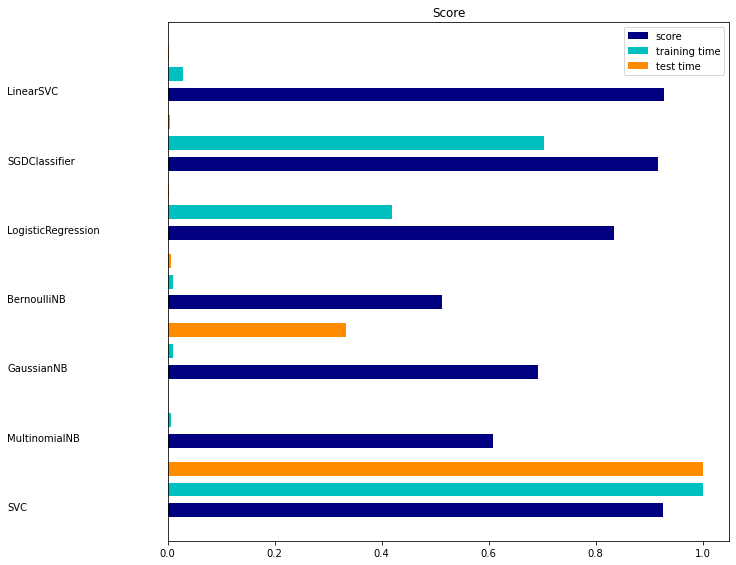

In [49]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()